In [2]:
import sys 
from  pathlib import Path


nvmrilib_path = Path(r"C:\Users\Konstantin\PycharmProjects\mlsvd_python\NVisionMRILib")
sys.path.append(str(nvmrilib_path))


In [4]:
from nvmrilib.read.nvdataset import NVDataset
from nvmrilib.read.jcampdx import JCAMPDX
from pathlib import Path
import json
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from scipy.signal import find_peaks

The reco pipeline for the hyperpolarized data

In [5]:
# Load data sets
local_config_json = Path(r"C:\Users\Konstantin\PycharmProjects\mlsvd_python\data_config.json")
localconfig = json.load(local_config_json.open())
DATA_DIR = Path(localconfig["suite_data_dir"])
ANATOMICAL = "anatomical"
HYPER = "hyper"
FOLDER_NAME = "reco"
jcamp_reco_path = "/pdata/1/reco"

In [6]:
def read_in(NAME):
    data = []
    for p1 in localconfig[NAME]:
        d1 = []
        for p2 in localconfig[NAME][p1]:
            temp_path = localconfig[NAME][p1][p2]
            path = f"{DATA_DIR}/{temp_path}"
            d1.append(
                {
                    "data": NVDataset(path),
                    "reco_params": JCAMPDX(f"{path}{jcamp_reco_path}"),
                    "name": p2,
                    "set": p1.split("_"),
                }
            )
        data.append(d1)
    return data

In [7]:
anat_data = read_in(ANATOMICAL)
hyper_csi = read_in(HYPER)

reordering enc_steps 0
reordering enc_steps 1
reordering enc_steps 0
reordering enc_steps 1
reordering enc_steps 0
reordering enc_steps 1
reordering enc_steps 0
reordering enc_steps 1
reordering enc_steps 0
reordering enc_steps 1
reordering enc_steps 0
reordering enc_steps 1
reordering enc_steps 0
reordering enc_steps 1
reordering enc_steps 0
reordering enc_steps 1
reordering enc_steps 0
reordering enc_steps 1
reordering enc_steps 0
reordering enc_steps 1
reordering enc_steps 0
reordering enc_steps 1
reordering enc_steps 0
reordering enc_steps 1
reordering enc_steps 0
reordering enc_steps 1


In [8]:
import os

# itterator über den Datensatz
i = 8

# filename to save plots and data - erstelle einen data folder :)

# flatten des hyper_csi arrays
hyper = [
	x for xs in hyper_csi for x in xs
]
csidata = hyper[i]["data"]
filename = f"data/{hyper[i]['name']}"  # 'name' field in hyper corresponds to the dataset name
os.makedirs(rf"C:\Users\Konstantin\PycharmProjects\mlsvd_python\{filename}", exist_ok=True)

csi_reco_params = hyper[i]["reco_params"]

# Infos über den Datensatz - Achtung nicht alle haben spacial dim 14,8, manche haben 8,14
print(csidata.dim_type)
print(csidata.data.shape)
print(filename)

['time', 'x', 'y', 'repetition']
(80, 14, 8, 42)
data/dataset10


Beispiel Singlepulse - falls notwendig

# Reco CSI

1. Transform CSI Data

In [9]:
# time domain
csidata.apodization()
csidata.fft('time')
csidata.fftshift('time')

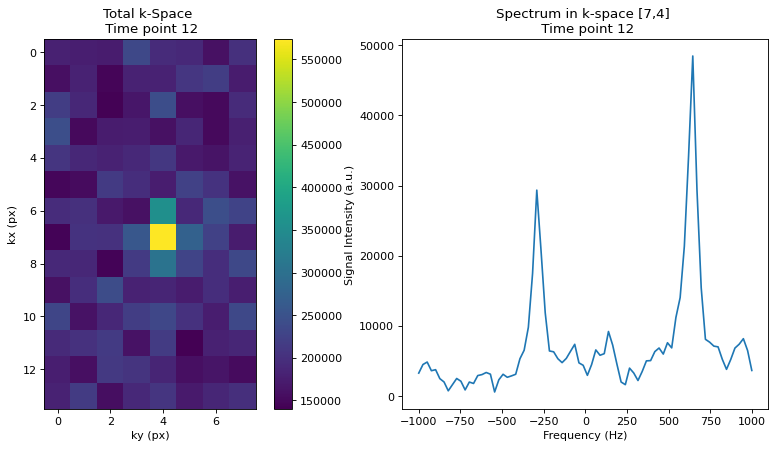

In [10]:
# auswählen des Zeitpunktes für gutes Bild mit signal
tp = 12

figure(figsize = (13,6),  dpi = 80)
# display k-space
plt.subplot(1,2,1)
plt.imshow(np.sum(np.abs(csidata.data[:,:,:,tp]),axis=0))
plt.title(f'Total k-Space \n Time point {tp}')
plt.xlabel('ky (px)')
plt.ylabel('kx (px)')
plt.colorbar()
# display spectrum
plt.subplot(1,2,2)
plt.plot(csidata.freq_axis,  np.abs(csidata.data[:,7,4,tp]))
plt.title(f'Spectrum in k-space [7,4] \n Time point {tp}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Signal Intensity (a.u.)')


plt.savefig(f'./{filename}/1.kspace_spectrum.png')

plt.show()

Transform spacial data

In [27]:
# verbessern der resolution
csidata.zeropad('x',4)
csidata.zeropad('y',4)

csidata.fftshift(['x', 'y'])
csidata.fft2(['x','y'])

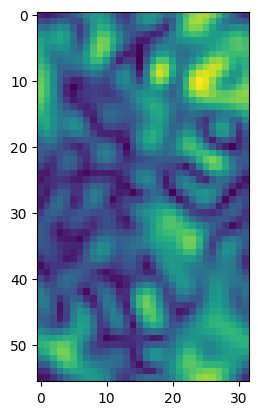

In [28]:
# spezifisch wegen scanner - einfach drin lassen - bei Datensatz 10 und 11 (?) mit dim (8,14) müssen die shifts entsprechend vertauscht werden -> siehe unten
tp=12
rotate = csi_reco_params["RECO_rotate"].value
#x_roll = int((1-rotate[1][0]) * csidata.data.shape[1])
#y_roll = int((1-rotate[2][0]) * csidata.data.shape[2])
# for n10 and n11 as x and y axis are switched
x_roll = int((1-rotate[2][0]) * csidata.data.shape[1])
y_roll = int((1-rotate[1][0]) * csidata.data.shape[2])
csidata.data = np.roll(csidata.data, (x_roll, y_roll), axis=(1,2))
plt.imshow(np.abs(csidata.data[28,:,:,tp+1]))

plt.savefig(f'./{filename}/1.spatial_transform.png')
plt.show()


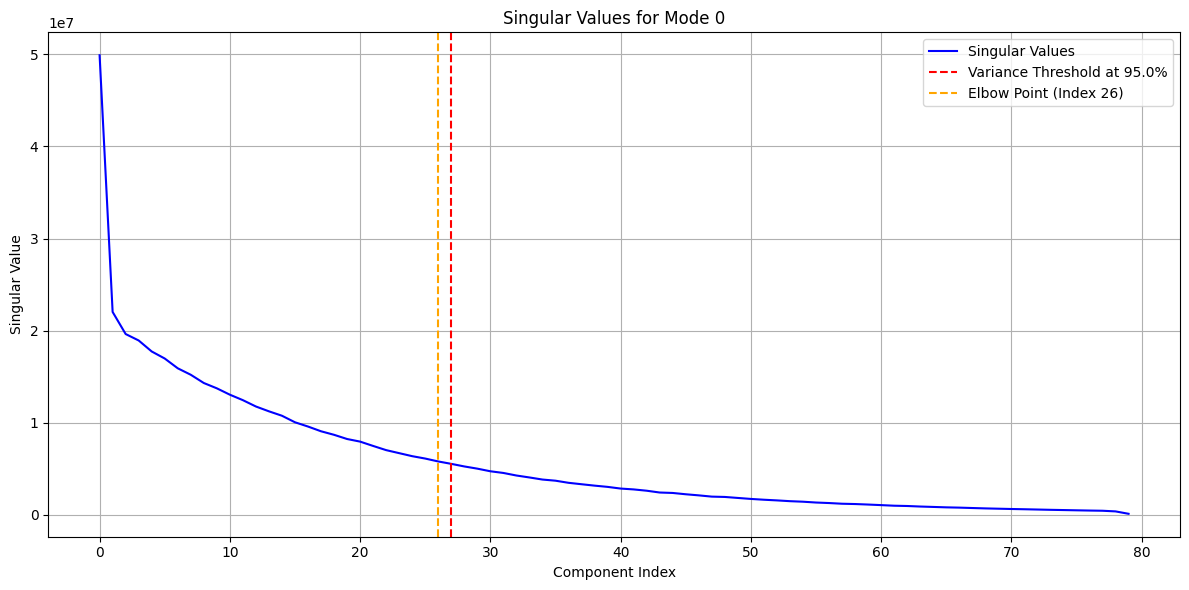

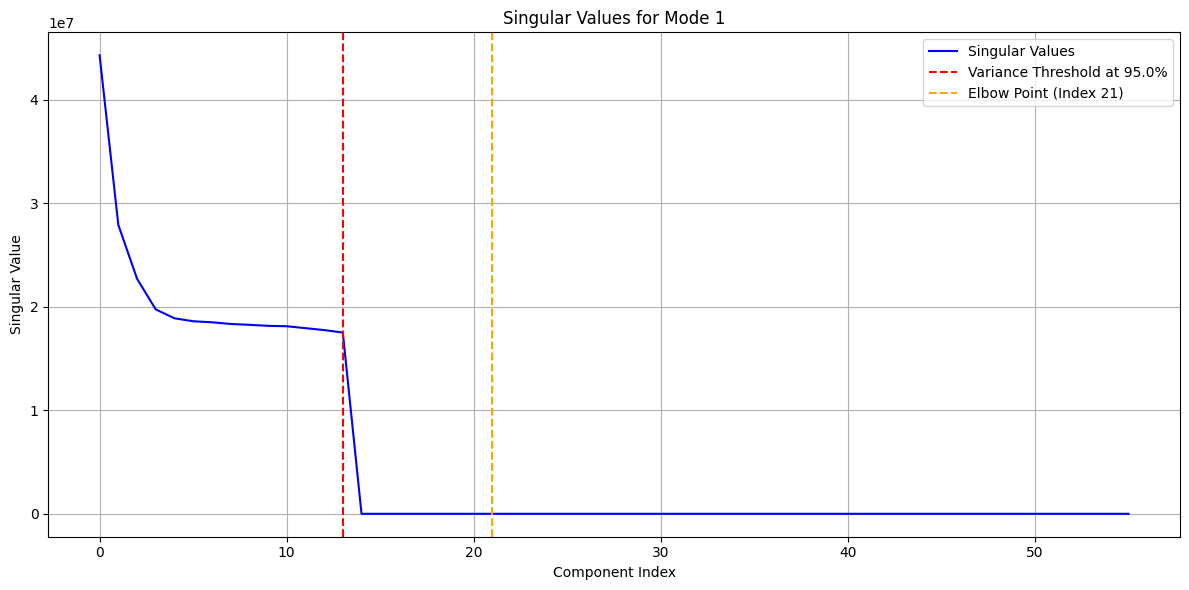

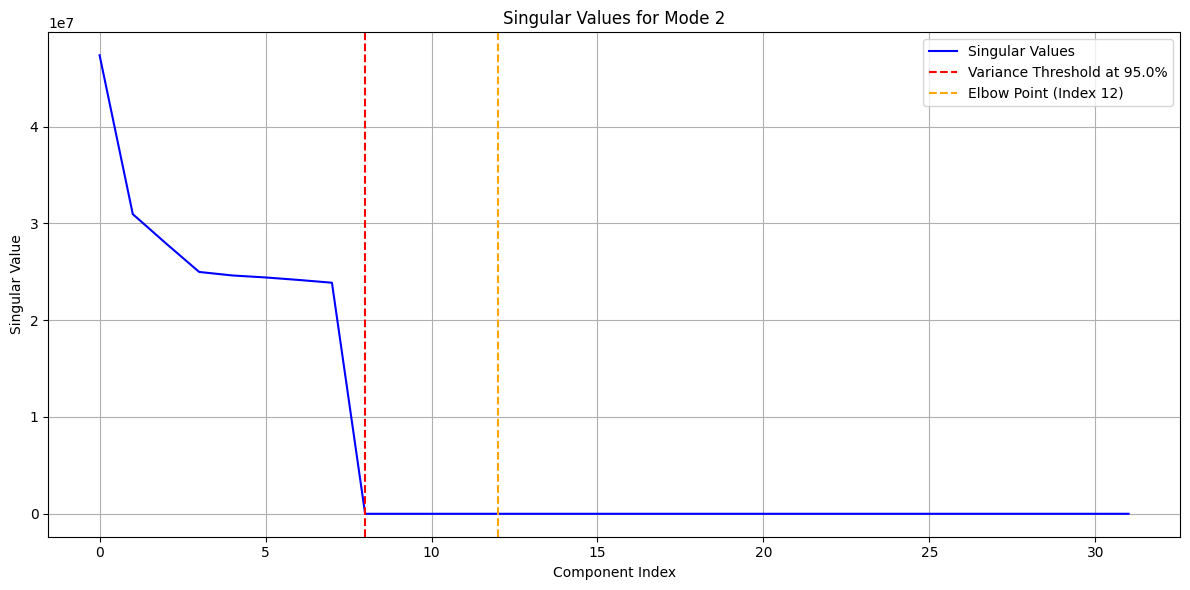

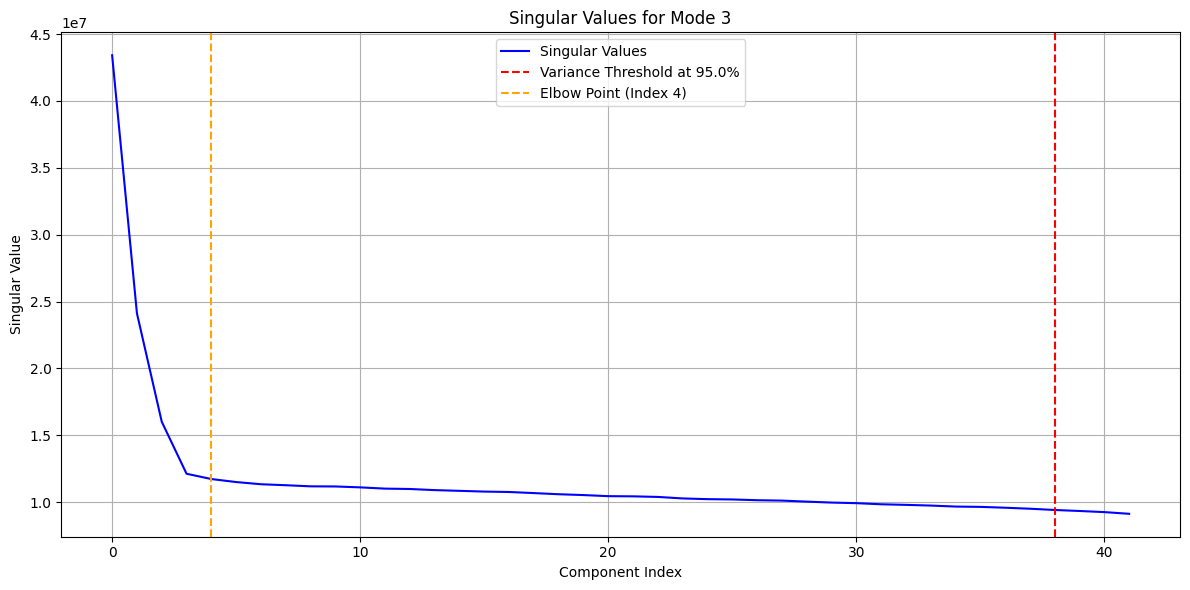

In [30]:
from kneed import KneeLocator
from numpy.linalg import svd
from tensorly import unfold

significant_components = []
plot = True
tensor = csidata.data

for mode in range(tensor.ndim):
    # Unfold the tensor along the current mode
    unfolded = unfold(tensor, mode)

    # Perform SVD to get singular values
    _, singular_values, _ = svd(unfolded, full_matrices=False)

    # Step 1: Compute Explained Variance
    explained_variance = np.cumsum(singular_values ** 2) / np.sum(singular_values ** 2)
    num_components_variance = np.argmax(explained_variance >= 0.95) + 1

    # Step 2: Use KneeLocator to find the elbow point
    knee_locator = KneeLocator(
        range(len(singular_values)),
        singular_values,
        curve="convex",
        direction="decreasing",
        online=True,
        interp_method="polynomial"
    )
    elbow_index = knee_locator.knee if knee_locator.knee is not None else len(singular_values) - 1

    # Step 3: Combine Results
    final_index = max(elbow_index, num_components_variance)

    # Append result for the current mode
    significant_components.append(final_index)

    # Plotting if plot=True
    if plot:
        plt.figure(figsize=(12, 6))

        # Plot singular values
        plt.plot(singular_values, label='Singular Values', color='b')
        plt.axvline(x=num_components_variance, color='r', linestyle='--',
                    label=f'Variance Threshold at {0.95 * 100}%')
        plt.axvline(x=elbow_index, color='orange', linestyle='--', label=f'Elbow Point (Index {elbow_index})')
        
        plt.title(f'Singular Values for Mode {mode}')
        plt.xlabel('Component Index')
        plt.ylabel('Singular Value')
            
        plt.legend()

        plt.grid(True)
        
        

        plt.tight_layout()
        plt.savefig(f'./{filename}/singular_value_mode_{mode}.png')

        
        
        plt.show()


Looking for the lactate peak

(80, 56, 32, 42)


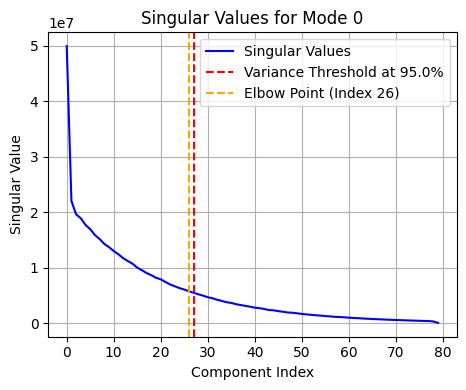

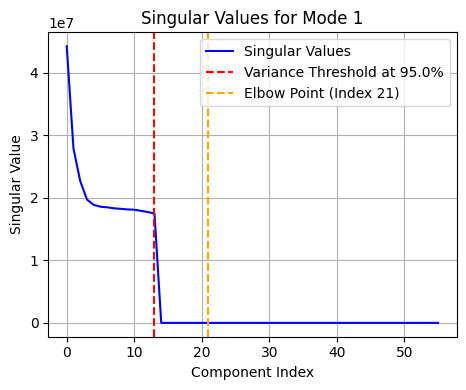

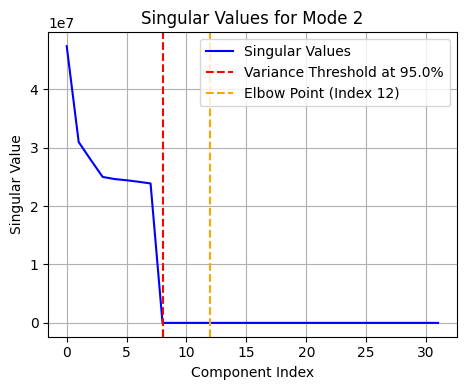

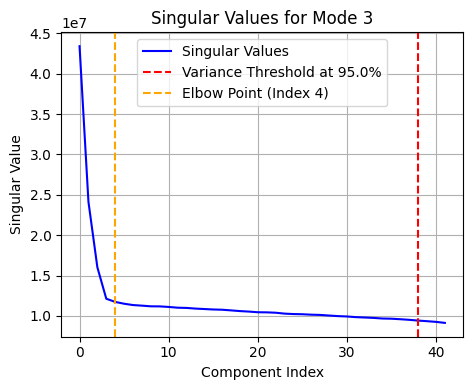

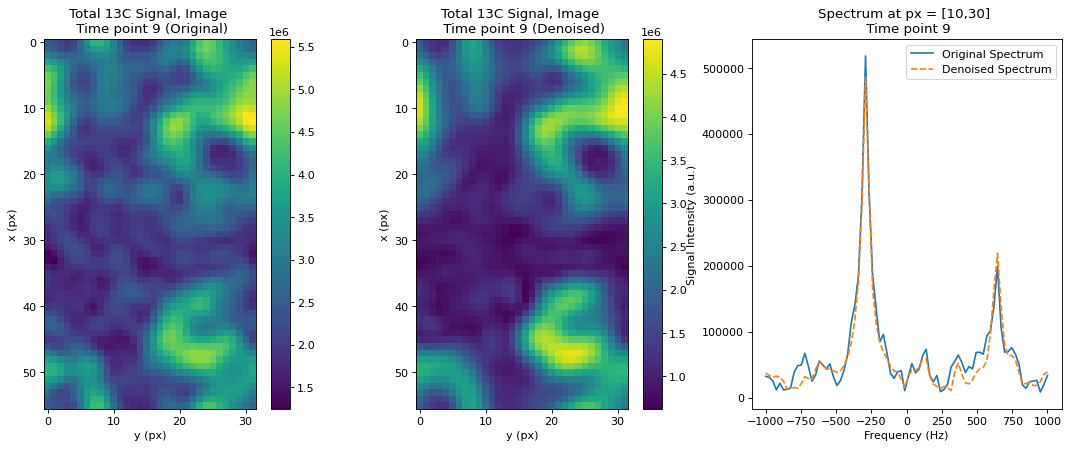

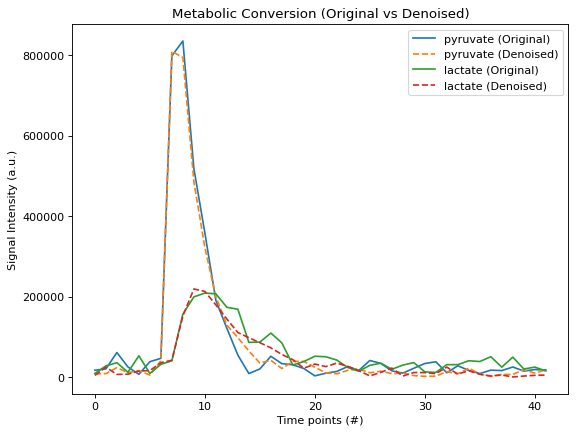

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import tr_denoising
# Assuming you have csidata and denoised function already defined
print(csidata.data.shape)
denoised_data = tr_denoising.tr_denoising(csidata.data)  # Apply denoising method to the data


tp = 9  # Set the time point for plotting
x, y = 10, 30  # Example pixel location (adjust as needed)

# Set up figure for 3 subplots (image, spectrum, time curve)
plt.figure(figsize=(17, 6), dpi=80)

# Display original vs. denoised 13C signal image
plt.subplot(1, 3, 1)
plt.imshow(np.sum(np.abs(csidata.data[:, :, :, tp]), axis=0))
plt.title(f'Total 13C Signal, Image \n Time point {tp} (Original)')
plt.xlabel('y (px)')
plt.ylabel('x (px)')
plt.colorbar()

# Display denoised 13C signal image
plt.subplot(1, 3, 2)
plt.imshow(np.sum(np.abs(denoised_data[:, :, :, tp]), axis=0))
plt.title(f'Total 13C Signal, Image \n Time point {tp} (Denoised)')
plt.xlabel('y (px)')
plt.ylabel('x (px)')
plt.colorbar()

# Display spectrum for original data
plt.subplot(1, 3, 3)
plt.plot(csidata.freq_axis, np.abs(csidata.data[:, x, y, tp]), label="Original Spectrum")
plt.plot(csidata.freq_axis, np.abs(denoised_data[:, x, y, tp]), label="Denoised Spectrum", linestyle='--')
plt.title(f'Spectrum at px = [{x},{y}] \n Time point {tp}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Signal Intensity (a.u.)')
plt.legend()

# Optional: Save the plot if needed
plt.savefig(f'./{filename}/comparison_image_spectrum.png')

# Show the plot
plt.show()

# Display time curve comparison
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(np.abs(csidata.data[28, x, y, :]), label="pyruvate (Original)")
plt.plot(np.abs(denoised_data[28, x, y, :]), label="pyruvate (Denoised)", linestyle='--')
plt.plot(np.abs(csidata.data[65, x, y, :]), label="lactate (Original)")
plt.plot(np.abs(denoised_data[65, x, y, :]), label="lactate (Denoised)", linestyle='--')
plt.legend(loc='upper right')
plt.title('Metabolic Conversion (Original vs Denoised)')
plt.xlabel('Time points (#)')
plt.ylabel('Signal Intensity (a.u.)')

# Optional: Save the time curve plot if needed
plt.savefig(f'./{filename}/time_curve_comparison.png')

# Show the plot
plt.show()


(80, 56, 32, 42)


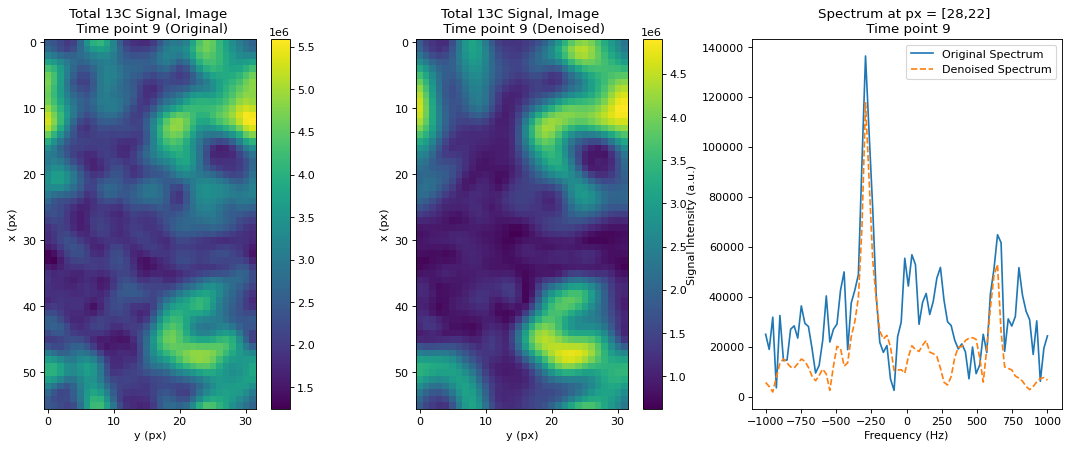

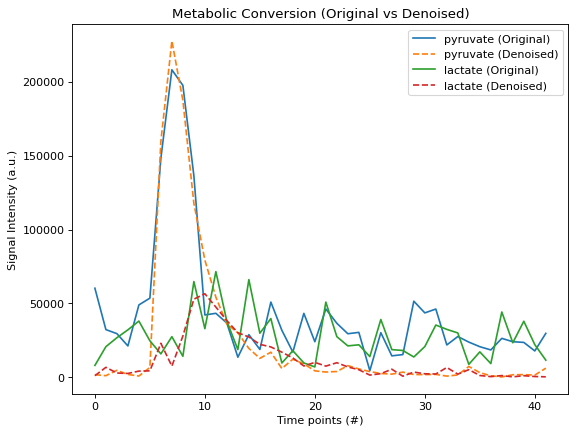

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import tr_denoising
# Assuming you have csidata and denoised function already defined
print(csidata.data.shape)


tp = 9  # Set the time point for plotting
x, y = 28, 22  # Example pixel location (adjust as needed)

# Set up figure for 3 subplots (image, spectrum, time curve)
plt.figure(figsize=(17, 6), dpi=80)

# Display original vs. denoised 13C signal image
plt.subplot(1, 3, 1)
plt.imshow(np.sum(np.abs(csidata.data[:, :, :, tp]), axis=0))
plt.title(f'Total 13C Signal, Image \n Time point {tp} (Original)')
plt.xlabel('y (px)')
plt.ylabel('x (px)')
plt.colorbar()

# Display denoised 13C signal image
plt.subplot(1, 3, 2)
plt.imshow(np.sum(np.abs(denoised_data[:, :, :, tp]), axis=0))
plt.title(f'Total 13C Signal, Image \n Time point {tp} (Denoised)')
plt.xlabel('y (px)')
plt.ylabel('x (px)')
plt.colorbar()

# Display spectrum for original data
plt.subplot(1, 3, 3)
plt.plot(csidata.freq_axis, np.abs(csidata.data[:, x, y, tp]), label="Original Spectrum")
plt.plot(csidata.freq_axis, np.abs(denoised_data[:, x, y, tp]), label="Denoised Spectrum", linestyle='--')
plt.title(f'Spectrum at px = [{x},{y}] \n Time point {tp}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Signal Intensity (a.u.)')
plt.legend()

# Optional: Save the plot if needed
plt.savefig(f'./{filename}/comparison_image_spectrum_tp_{tp}_x_{x}_y_{y}.png')

# Show the plot
plt.show()

# Display time curve comparison
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(np.abs(csidata.data[28, x, y, :]), label="pyruvate (Original)")
plt.plot(np.abs(denoised_data[28, x, y, :]), label="pyruvate (Denoised)", linestyle='--')
plt.plot(np.abs(csidata.data[65, x, y, :]), label="lactate (Original)")
plt.plot(np.abs(denoised_data[65, x, y, :]), label="lactate (Denoised)", linestyle='--')
plt.legend(loc='upper right')
plt.title('Metabolic Conversion (Original vs Denoised)')
plt.xlabel('Time points (#)')
plt.ylabel('Signal Intensity (a.u.)')

# Optional: Save the time curve plot if needed
plt.savefig(f'./{filename}/time_curve_comparison_tp_{tp}_x_{x}_y_{y}.png')

# Show the plot
plt.show()


In [48]:
import numpy as np
import pandas as pd

# Extract the time-series data you plotted
pyruvate_orig = np.abs(csidata.data[28, x, y, :])
pyruvate_denoised = np.abs(denoised_data[28, x, y, :])
lactate_orig = np.abs(csidata.data[65, x, y, :])
lactate_denoised = np.abs(denoised_data[65, x, y, :])

# Compute AUC using trapezoidal numerical integration
auc_pyruvate_orig = np.trapz(pyruvate_orig)
auc_pyruvate_denoised = np.trapz(pyruvate_denoised)
auc_lactate_orig = np.trapz(lactate_orig)
auc_lactate_denoised = np.trapz(lactate_denoised)

print("AUC (Pyruvate, Original):", auc_pyruvate_orig)
print("AUC (Pyruvate, Denoised):", auc_pyruvate_denoised)
print("AUC (Lactate, Original):", auc_lactate_orig)
print("AUC (Lactate, Denoised):", auc_lactate_denoised)

# If you want the ratio of lactate to pyruvate AUC:
ratio_orig = auc_lactate_orig / auc_pyruvate_orig
ratio_denoised = auc_lactate_denoised / auc_pyruvate_denoised

print("Lactate-to-Pyruvate Ratio (Original):", ratio_orig)
print("Lactate-to-Pyruvate Ratio (Denoised):", ratio_denoised)

# Create a dictionary for the data
data_dict = {
    'Metric': ['AUC Pyruvate', 'AUC Lactate', 'Lactate-to-Pyruvate Ratio'],
    'Original': [auc_pyruvate_orig, auc_lactate_orig, ratio_orig],
    'Denoised': [auc_pyruvate_denoised, auc_lactate_denoised, ratio_denoised]
}

# Convert the dictionary into a pandas DataFrame
df = pd.DataFrame(data_dict)

# Print the DataFrame
print(df)

# Save the DataFrame as a CSV file
df.to_csv('auc_metrics.csv', index=False)

AUC (Pyruvate, Original): 3687416.1653558165
AUC (Pyruvate, Denoised): 3432256.3393143932
AUC (Lactate, Original): 2448549.371876968
AUC (Lactate, Denoised): 1833526.016249085
Lactate-to-Pyruvate Ratio (Original): 0.6640284855508561
Lactate-to-Pyruvate Ratio (Denoised): 0.5342042770078587
                      Metric      Original      Denoised
0               AUC Pyruvate  3.687416e+06  3.432256e+06
1                AUC Lactate  2.448549e+06  1.833526e+06
2  Lactate-to-Pyruvate Ratio  6.640285e-01  5.342043e-01


C:\Users\Konstantin\AppData\Local\Temp\ipykernel_14028\3001441705.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pyruvate_orig = np.trapz(pyruvate_orig)
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_14028\3001441705.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pyruvate_denoised = np.trapz(pyruvate_denoised)
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_14028\3001441705.py:13: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_lactate_orig = np.trapz(lactate_orig)
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_14028\3001441705.py:14: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_lactate_denois

In [45]:
import numpy as np

# Select a time point for spectral analysis
tp = 9  # for example

# Extract the frequency axis and spectra at (x,y) and time point tp
freq = csidata.freq_axis
original_spectrum = np.abs(csidata.data[:, x, y, tp])
denoised_spectrum = np.abs(denoised_data[:, x, y, tp])

# Define metabolite indices (example: pyruvate_idx = 28, lactate_idx = 65)
pyruvate_idx = 28
lactate_idx = 65

# Choose a frequency window around each peak. 
# Adjust these windows based on your knowledge of the peak location and linewidth.
window = 5.0  # Hz window around the peak center (example value)

# Function to compute spectral metrics for a given metabolite
def compute_spectral_metrics(spectrum, freq_axis, center_idx, freq_window=5.0):
    center_freq = freq_axis[center_idx]
    mask = (freq_axis >= center_freq - freq_window) & (freq_axis <= center_freq + freq_window)
    
    # Isolated frequency and spectrum portion
    f_subset = freq_axis[mask]
    s_subset = spectrum[mask]
    
    # Peak height
    peak_height = np.max(s_subset)
    peak_pos = f_subset[np.argmax(s_subset)]
    
    # Peak area (frequency-domain AUC)
    peak_area = np.trapz(s_subset, x=f_subset)
    
    # Compute FWHM: find frequency points where spectrum = peak_height/2
    half_height = peak_height / 2.0
    
    # Indices where spectrum crosses half height
    above_half = s_subset >= half_height
    # We need the first and last points in this region to determine the FWHM boundaries
    if np.any(above_half):
        # Extract indices of the subset region where value is above half
        above_indices = np.where(above_half)[0]
        fwhm_left_idx = f_subset[above_indices[0]]
        fwhm_right_idx = f_subset[above_indices[-1]]
        fwhm = fwhm_right_idx - fwhm_left_idx
    else:
        fwhm = np.nan  # If we can't find a half-height crossing, something is off or peak is too weak.
    
    # Optional: Peak asymmetry: compare integrated areas on left and right half of peak maximum
    left_mask = f_subset < peak_pos
    right_mask = f_subset > peak_pos
    left_area = np.trapz(s_subset[left_mask], x=f_subset[left_mask]) if np.any(left_mask) else 0
    right_area = np.trapz(s_subset[right_mask], x=f_subset[right_mask]) if np.any(right_mask) else 0
    # Asymmetry ratio (close to 1.0 means symmetric)
    asymmetry_ratio = left_area / right_area if right_area != 0 else np.nan
    
    return {
        'peak_height': peak_height,
        'peak_area': peak_area,
        'fwhm': fwhm,
        'peak_pos': peak_pos,
        'asymmetry_ratio': asymmetry_ratio
    }

# Compute spectral metrics for Pyruvate - Original vs Denoised
pyruvate_orig_metrics = compute_spectral_metrics(original_spectrum, freq, pyruvate_idx, freq_window=100.0)
pyruvate_denoised_metrics = compute_spectral_metrics(denoised_spectrum, freq, pyruvate_idx, freq_window=100.0)

# Compute spectral metrics for Lactate - Original vs Denoised
lactate_orig_metrics = compute_spectral_metrics(original_spectrum, freq, lactate_idx, freq_window=100.0)
lactate_denoised_metrics = compute_spectral_metrics(denoised_spectrum, freq, lactate_idx, freq_window=100.0)

# Print out the results
print("Pyruvate (Original) Spectral Metrics:", pyruvate_orig_metrics)
print("Pyruvate (Denoised) Spectral Metrics:", pyruvate_denoised_metrics)
print("Lactate (Original) Spectral Metrics:", lactate_orig_metrics)
print("Lactate (Denoised) Spectral Metrics:", lactate_denoised_metrics)


Pyruvate (Original) Spectral Metrics: {'peak_height': np.float64(518291.6586483138), 'peak_area': np.float64(41529305.61689254), 'fwhm': np.float64(50.632911392405106), 'peak_pos': np.float64(-291.1392405063291), 'asymmetry_ratio': np.float64(0.9986233014237237)}
Pyruvate (Denoised) Spectral Metrics: {'peak_height': np.float64(485978.31705353456), 'peak_area': np.float64(39184544.61362481), 'fwhm': np.float64(50.632911392405106), 'peak_pos': np.float64(-291.1392405063291), 'asymmetry_ratio': np.float64(1.012008947581238)}
Lactate (Original) Spectral Metrics: {'peak_height': np.float64(199502.28843168492), 'peak_area': np.float64(17648878.588020783), 'fwhm': np.float64(75.94936708860746), 'peak_pos': np.float64(645.5696202531644), 'asymmetry_ratio': np.float64(1.380660710747787)}
Lactate (Denoised) Spectral Metrics: {'peak_height': np.float64(219124.4018767341), 'peak_area': np.float64(19153220.809368774), 'fwhm': np.float64(50.63291139240505), 'peak_pos': np.float64(645.5696202531644),

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_14028\1878413724.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  peak_area = np.trapz(s_subset, x=f_subset)
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_14028\1878413724.py:53: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  left_area = np.trapz(s_subset[left_mask], x=f_subset[left_mask]) if np.any(left_mask) else 0
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_14028\1878413724.py:54: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  right_area = np.trapz(s_subset[right_mask], x=f_subset[right_mask]) if np.any(right_mask) else 0


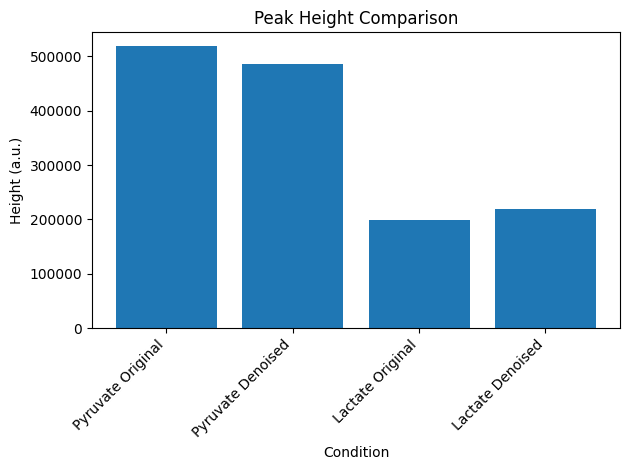

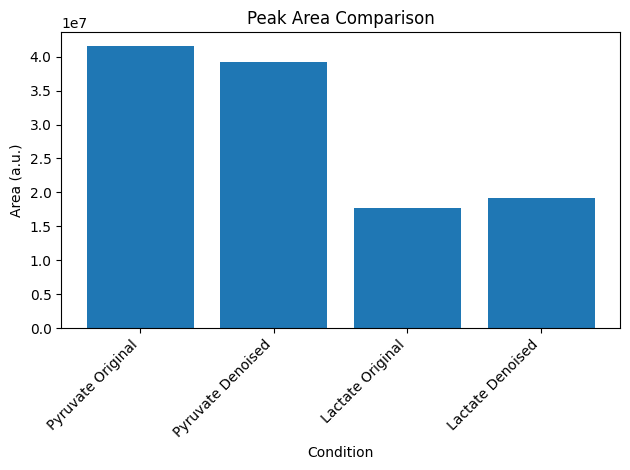

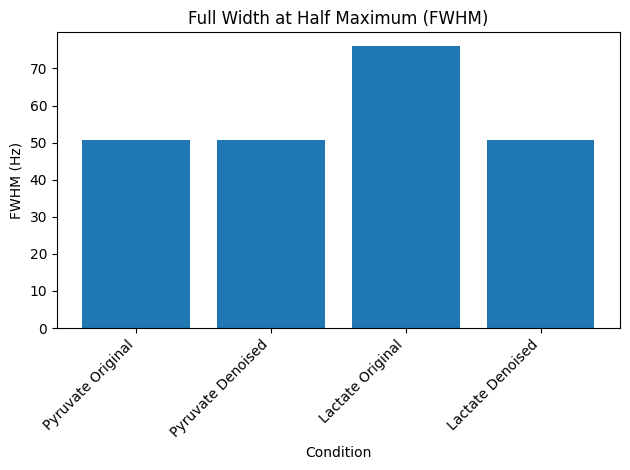

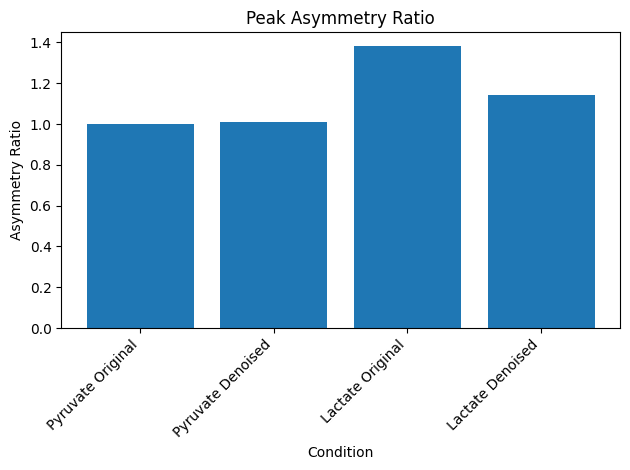

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# After computing the metrics as shown previously:
# pyruvate_orig_metrics, pyruvate_denoised_metrics, lactate_orig_metrics, lactate_denoised_metrics
# Each of these is a dictionary, for example:
# pyruvate_orig_metrics = {'peak_height': ..., 'peak_area': ..., 'fwhm': ..., 'peak_pos': ..., 'asymmetry_ratio': ...}

labels = ['Pyruvate Original', 'Pyruvate Denoised', 'Lactate Original', 'Lactate Denoised']

# 1) Plot for Peak Height
peak_height_values = [
    pyruvate_orig_metrics['peak_height'],
    pyruvate_denoised_metrics['peak_height'],
    lactate_orig_metrics['peak_height'],
    lactate_denoised_metrics['peak_height']
]

plt.figure()
plt.bar(np.arange(len(peak_height_values)), peak_height_values)
plt.xticks(np.arange(len(peak_height_values)), labels, rotation=45, ha='right')
plt.title('Peak Height Comparison')
plt.xlabel('Condition')
plt.ylabel('Height (a.u.)')
plt.tight_layout()
plt.show()

# 2) Plot for Peak Area
peak_area_values = [
    pyruvate_orig_metrics['peak_area'],
    pyruvate_denoised_metrics['peak_area'],
    lactate_orig_metrics['peak_area'],
    lactate_denoised_metrics['peak_area']
]

plt.figure()
plt.bar(np.arange(len(peak_area_values)), peak_area_values)
plt.xticks(np.arange(len(peak_area_values)), labels, rotation=45, ha='right')
plt.title('Peak Area Comparison')
plt.xlabel('Condition')
plt.ylabel('Area (a.u.)')
plt.tight_layout()
plt.show()

# 3) Plot for FWHM
fwhm_values = [
    pyruvate_orig_metrics['fwhm'],
    pyruvate_denoised_metrics['fwhm'],
    lactate_orig_metrics['fwhm'],
    lactate_denoised_metrics['fwhm']
]

plt.figure()
plt.bar(np.arange(len(fwhm_values)), fwhm_values)
plt.xticks(np.arange(len(fwhm_values)), labels, rotation=45, ha='right')
plt.title('Full Width at Half Maximum (FWHM)')
plt.xlabel('Condition')
plt.ylabel('FWHM (Hz)')
plt.tight_layout()
plt.show()

# 4) Plot for Asymmetry Ratio
asymmetry_values = [
    pyruvate_orig_metrics['asymmetry_ratio'],
    pyruvate_denoised_metrics['asymmetry_ratio'],
    lactate_orig_metrics['asymmetry_ratio'],
    lactate_denoised_metrics['asymmetry_ratio']
]

plt.figure()
plt.bar(np.arange(len(asymmetry_values)), asymmetry_values)
plt.xticks(np.arange(len(asymmetry_values)), labels, rotation=45, ha='right')
plt.title('Peak Asymmetry Ratio')
plt.xlabel('Condition')
plt.ylabel('Asymmetry Ratio')
plt.tight_layout()
plt.show()


Denoising

Finding the peaks

(array([], dtype=int64), {'peak_heights': array([], dtype=float64)})


IndexError: index 0 is out of bounds for axis 0 with size 0

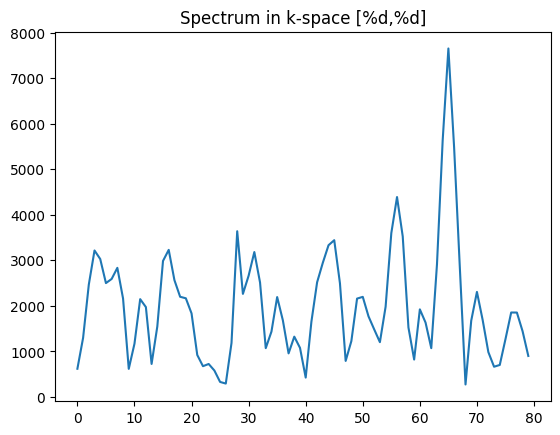

In [35]:
# plot spectrum without freq_axis to extract the indices of pyr and lac peaks
tp=21
#plt.plot( np.abs(csidata.data[:,x,y,:]))
plt.plot(np.abs(denoised_data[:,x,y,tp]))
plt.title('Spectrum in k-space [%d,%d]')



# getting the peaks
peaks = find_peaks(np.abs(csidata.data[:,x,y,tp]), height = 100_000)
peaks = find_peaks(np.abs(denoised_data[:,x,y,tp]), height = 100_000)

print(peaks)

pyr_idx = peaks[0][0] # im Regelfall 27,28
lac_idx = peaks[0][-1] # im Regelfall 64,65

Text(0, 0.5, 'Signal Intensity (a.u.)')

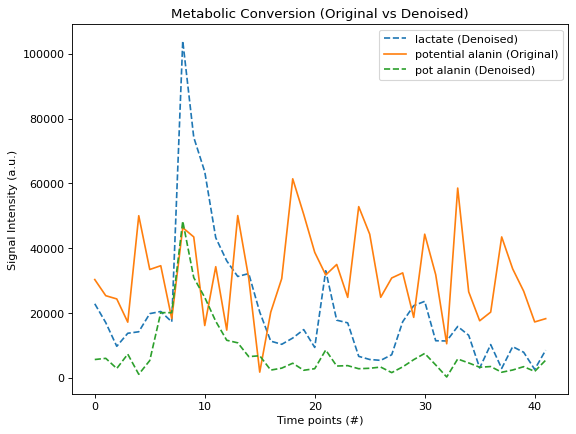

In [17]:
# Display time curve comparison
plt.figure(figsize=(8, 6), dpi=80)
#plt.plot(np.abs(csidata.data[28, x, y, :]), label="pyruvate (Original)")
#plt.plot(np.abs(denoised_data[28, x, y, :]), label="pyruvate (Denoised)", linestyle='--')
#plt.plot(np.abs(csidata.data[65, x, y, :]), label="lactate (Original)")
plt.plot(np.abs(denoised_data[65, x, y, :]), label="lactate (Denoised)", linestyle='--')

plt.plot(np.abs(csidata.data[69, x, y, :]), label="potential alanin (Original)")
plt.plot(np.abs(denoised_data[69, x, y, :]), label="pot alanin (Denoised)", linestyle='--')
plt.legend(loc='upper right')
plt.title('Metabolic Conversion (Original vs Denoised)')
plt.xlabel('Time points (#)')
plt.ylabel('Signal Intensity (a.u.)')


In [18]:
# Define the range of time points (you said you have 42 time points)
n_time_points = 40  # Adjust if necessary, depending on the actual number of time points

# Loop over all time points (you can adjust this based on your time point range)
for tp in range(n_time_points):
    
    peaks, _ = find_peaks(np.abs(denoised_data[:, x, y, tp]), height=10_000)

    if peaks.size >0 and tp >20:
        print(tp, peaks)
    else:
        pass

# 20 -> 19tp und 78  -> tp 27

21 [ 2 16 28 46 56 66 73 76]
22 [16 28 32 45 65]
23 [28 65]
24 [28]
25 [28]
26 [28]
27 [28]
28 [15 24 28 66]
29 [15 25 28 66]
30 [28 32 45 66 74 76]
31 [28 66]
32 [28 65]
33 [28 66]
34 [66]
35 [28]
36 [66]
37 [28]
38 [28 66]
39 [28]


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Assuming img_out is your 4D denoised data array (time, x, y, frequency)
# Extract the data for a specific voxel (x, y) and a certain timepoint, if applicable
spectrum = np.abs(img_out[:, x, y, :])  # Assuming 'img_out' is [time, x, y, frequency]

# Now, `spectrum` is a 1D array over frequency (time axis is collapsed out)
# Find peaks in the 1D spectrum (frequency axis)
peaks, _ = find_peaks(spectrum, height=100000)  # Adjust height threshold as needed

# Print detected peaks
print('Detected peaks at indices:', peaks)

# Plot the spectrum with peaks marked
plt.plot(spectrum)
plt.plot(peaks, spectrum[peaks], "x", label='Detected peaks')
plt.title('Detected Peaks in Denoised Spectrum')
plt.xlabel('Frequency Index')
plt.ylabel('Magnitude')
plt.legend()
plt.show()


ValueError: `x` must be a 1-D array

In [33]:
from scipy.signal import find_peaks

# Find peaks in the magnitude spectrum (assuming img_out[:, x, y, :] holds the data for one spatial location)
peaks, _ = find_peaks(np.abs(img_out[:, x, y, :]), height=100000)  # Adjust height threshold as needed

# Print peak indices
print('Detected peaks at indices:', peaks)

# Plot the spectrum with peaks marked
plt.plot(np.abs(img_out[:, x, y, :]))
plt.plot(peaks, np.abs(img_out[:, x, y, :])[peaks], "x", label='Detected peaks')
plt.title('Detected Peaks in Denoised Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend()
plt.show()


ValueError: `x` must be a 1-D array

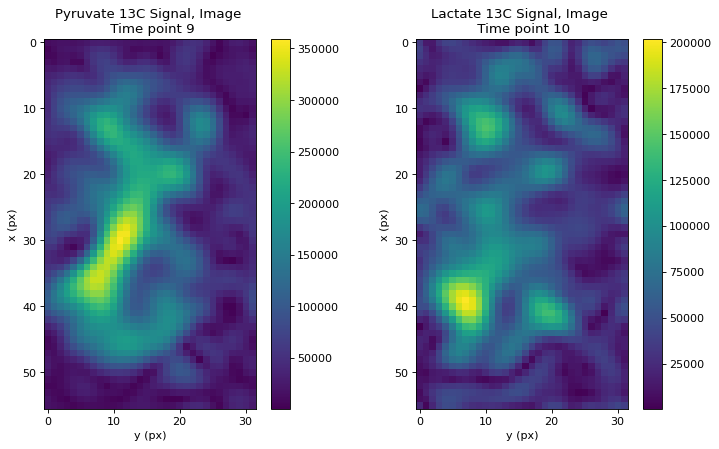

In [16]:
tp_lactat = 10

# display image
figure(figsize = (11,6),  dpi = 80)
# pyruvate image
plt.subplot(1,2,1)
plt.imshow(np.abs(csidata.data[pyr_idx,:,:,tp]))
plt.title('Pyruvate 13C Signal, Image \n Time point %d' % tp)
plt.xlabel('y (px)')
plt.ylabel('x (px)')
plt.colorbar()
# lactate image
plt.subplot(1,2,2)
plt.imshow(np.abs(csidata.data[lac_idx,:,:,tp_lactat]))
plt.title('Lactate 13C Signal, Image \n Time point %d' % tp_lactat)
plt.xlabel('y (px)')
plt.ylabel('x (px)')
plt.colorbar()

# plt.savefig(f'./{filename}/3.pyr_lac_image.png')

plt.show()

In [83]:
# save np arrays

pyr_image = csidata.data[pyr_idx,:,:,tp]
# np.save(f"./{filename}/pyruvate_{tp}.npy", pyr_image)
lac_image = csidata.data[lac_idx,:,:,tp_lactat]
# np.save(f"./{filename}/lactate_ {tp_lactat}.npy", lac_image)